In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import sklearn


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into dataframe </h2>

In [2]:
X_tr=pd.read_csv('X_tr.csv')
X_test=pd.read_csv('X_test.csv')
y_tr=pd.read_csv('y_tr.csv')
y_test=pd.read_csv('y_test.csv')

In [3]:
print("Number of data points in train data :",X_tr.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (3500, 12910)
Number of data points in test data : (1500, 12910)


In [4]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_len = len(y_tr)
print("Class 0: ",(y_tr.is_duplicate.eq(0).sum()/train_len),"Class 1: ", (y_tr.is_duplicate.eq(1).sum()/train_len))
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_len = len(y_test)
print("Class 0: ",(y_test.is_duplicate.eq(0).sum()/test_len), "Class 1: ",(y_test.is_duplicate.eq(1).sum()/test_len))

---------- Distribution of output variable in train data ----------
Class 0:  0.6177142857142857 Class 1:  0.3822857142857143
---------- Distribution of output variable in train data ----------
Class 0:  0.618 Class 1:  0.382


In [5]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8789081263101477


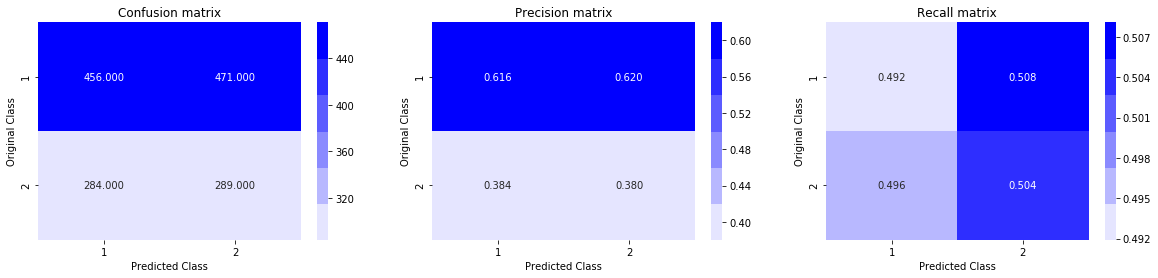

In [6]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.500186148847821
For values of alpha =  0.0001 The log loss is: 0.5057876566951888
For values of alpha =  0.001 The log loss is: 0.5048449352229515
For values of alpha =  0.01 The log loss is: 0.4981270516486394
For values of alpha =  0.1 The log loss is: 0.504342629303533
For values of alpha =  1 The log loss is: 0.5129398409491179
For values of alpha =  10 The log loss is: 0.5628065376056285


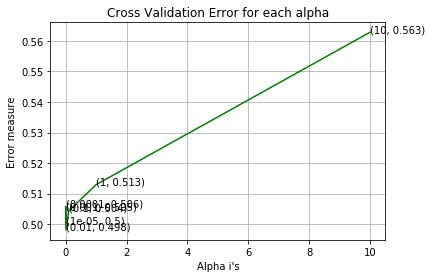

For values of best alpha =  0.01 The train log loss is: 0.48126383804455153
For values of best alpha =  0.01 The test log loss is: 0.4981270516486394
Total number of data points : 1500


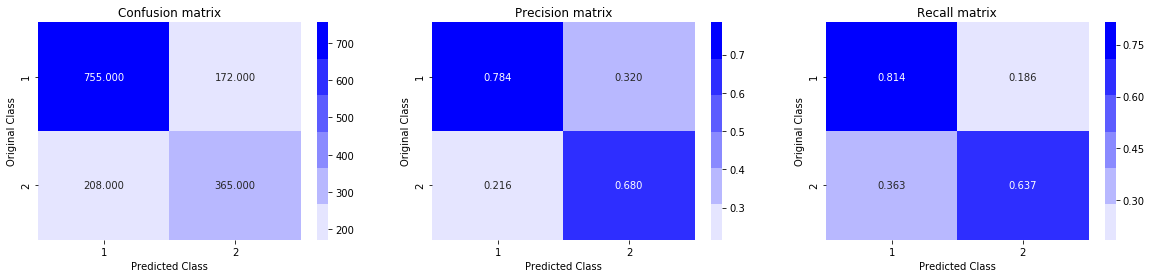

In [7]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_tr, y_tr.values.ravel())
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_tr.values.ravel())
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_tr, y_tr.values.ravel())
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, y_tr.values.ravel())

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4822340313924434
For values of alpha =  0.0001 The log loss is: 0.4737060469199218
For values of alpha =  0.001 The log loss is: 0.4759617053302182
For values of alpha =  0.01 The log loss is: 0.4913005685295455
For values of alpha =  0.1 The log loss is: 0.5500408825266706
For values of alpha =  1 The log loss is: 0.569956568495093
For values of alpha =  10 The log loss is: 0.6175745997366866


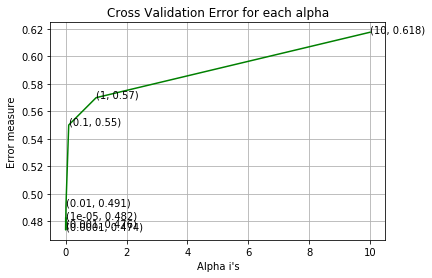

For values of best alpha =  0.0001 The train log loss is: 0.4692863142426669
For values of best alpha =  0.0001 The test log loss is: 0.4737060469199218
Total number of data points : 1500


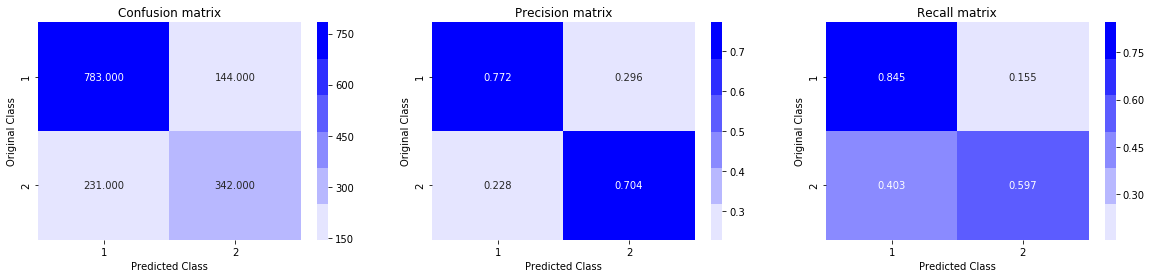

In [8]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_tr, y_tr.values.ravel())
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_tr.values.ravel())
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_tr, y_tr.values.ravel())
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, y_tr.values.ravel())

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


<h2> 4.6 XGBoost </h2>

In [10]:
xgb_model  = xgb.XGBClassifier(class_weight='balanced',n_jobs=-1)
param_grid = {
        'max_depth': [5,6],
        'n_estimators': [20,30]}
rand_search = RandomizedSearchCV(xgb_model, param_grid, cv=5,n_jobs=-1,random_state=42)


print("Randomized search..")
search_time_start = time.time()
rand_search.fit(X_tr, y_tr.values.ravel())
print("Randomized search time:", time.time() - search_time_start)

best_score = rand_search.best_score_
best_params = rand_search.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..


C:\Users\mchetankumar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Randomized search time: 285.7096531391144
Best score: 0.8034285714285714
Best params: 
max_depth: 5
n_estimators: 30


The train log loss is: 0.331736957258944
The test log loss is: 0.3933022991915544
Total number of data points : 1500


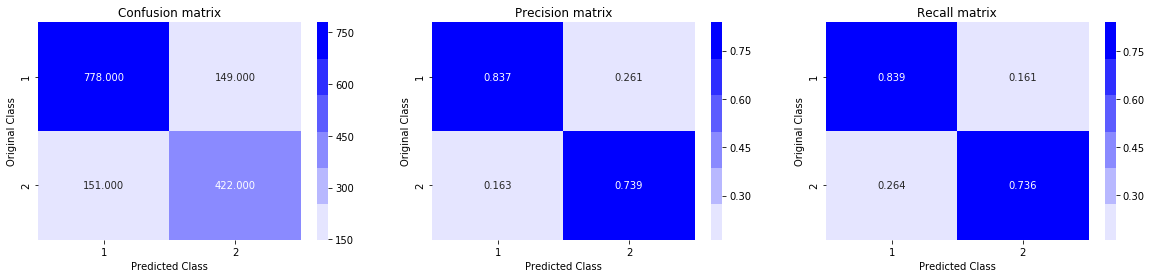

In [11]:
xgb_model = xgb.XGBClassifier(max_depth=best_params['max_depth'],n_estimators=best_params['n_estimators'],class_weight='balanced',n_jobs=-1)
xgb_model.fit(X_tr, y_tr.values.ravel())
y_train_pred=[]
y_test_pred=[]
for j in range(0, X_tr.shape[0], 1000):
    y_train_pred.extend(xgb_model.predict_proba(X_tr[j:j+1000])[:,1])
print("The train log loss is:",log_loss(y_tr, y_train_pred, labels=xgb_model.classes_, eps=1e-15))
for j in range(0, X_test.shape[0], 1000):
    y_test_pred.extend(xgb_model.predict_proba(X_test[j:j+1000])[:,1])
print("The test log loss is:",log_loss(y_test, y_test_pred, labels=xgb_model.classes_, eps=1e-15))

predicted_y =np.array(np.array(y_test_pred)>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)